In [ ]:
#Installs
!pip install datasets
!pip install clip_interrogator
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [ ]:
#Mount Drive
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Deep Learning Project')

Mounted at /content/drive/


In [ ]:
#Necessary libraries to import
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, models
from PIL import Image
from clip_interrogator import Config, Interrogator
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
#Load the dataset with the "2m_first_1k" subset
dataset = load_dataset('poloclub/diffusiondb', '2m_first_1k')
df = dataset['train'].to_pandas()
df['image'] = df['image'].apply(lambda x: x['path'])

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusiondb downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_1k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Set up CLIP Interrogator model
config = Config(clip_model_name="ViT-L-14/openai")
ci_vitl = Interrogator(config)
config.blip_model = ci_vitl.blip_model
config.clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
ci_vith = Interrogator(config)

Loading BLIP model...


  0%|          | 0.00/1.66G [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...



  0%|                                               | 0.00/933M [00:00<?, ?iB/s]
  1%|▎                                     | 8.49M/933M [00:00<00:10, 84.8MiB/s]
  2%|▊                                     | 19.3M/933M [00:00<00:09, 98.4MiB/s]
  3%|█▏                                     | 29.5M/933M [00:00<00:09, 100MiB/s]
  4%|█▌                                    | 39.5M/933M [00:00<00:11, 76.9MiB/s]
  5%|█▉                                    | 48.9M/933M [00:00<00:10, 82.0MiB/s]
  6%|██▎                                   | 57.6M/933M [00:00<00:10, 81.3MiB/s]
  7%|██▋                                   | 66.1M/933M [00:00<00:11, 73.8MiB/s]
  8%|███                                   | 73.7M/933M [00:00<00:11, 73.0MiB/s]
  9%|███▎                                  | 81.7M/933M [00:01<00:11, 74.8MiB/s]
 10%|███▋                                  | 90.8M/933M [00:01<00:10, 79.3MiB/s]
 11%|████                                  | 98.9M/933M [00:01<00:10, 77.1MiB/s]
 11%|████▍                 

Loaded CLIP model and data in 25.85 seconds.
Loading CLIP model...


Loaded CLIP model and data in 77.14 seconds.


In [ ]:
#Create function that will generate the prompt for a given image
def image_to_prompt(image_path, clip_model_name,length):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ci_vith.clip_model = ci_vith.clip_model.to(ci_vith.device)
    ci = ci_vith
    ci.config.blip_num_beams = 2
    ci.config.chunk_size = 512
    ci.config.flavor_intermediate_count = 512
    image = Image.open(image_path)

    prompt = ci.interrogate_fast(image)
    #Only include keywords/phrases up to the length limit specified in the function call
    return prompt.split(',')[0:length]

In [ ]:
#Get a sample prompt
prompt = image_to_prompt(df['image'][7],'ViT-H (best for Stable Diffusion 2.*)',20)

100%|██████████| 219/219 [00:00<00:00, 413.81it/s]


In [ ]:
prompt

['a couple of purple and white tubes next to a cigar',
 ' cigars',
 ' cigarettes',
 ' purple tubes',
 ' violet spike smoke',
 ' cigarette',
 ' smoking cigarettes',
 ' smoking cigars',
 ' cigar',
 ' purple smoke',
 ' stock and two smoking barrels',
 ' taking a smoke break',
 ' discarded scrolls',
 ' ashes and smoke columns',
 ' smoking a cigarrette🚬',
 ' subject action: smoking a cigar',
 ' inspired by William Harnett']

In [ ]:
#Set up embeddings
class CFG:
    device = "cuda"
    seed = 1
    embedding_length = 384
    sentence_model_path = 'sentence-transformers/all-MiniLM-L6-v2'

In [ ]:
st_model = SentenceTransformer(CFG.sentence_model_path)

In [ ]:
#Establish a function to get cosine similarity between two vectors
def get_cosine_similarity(vecA,vecB):
    cosine_score = metrics.pairwise.cosine_similarity([vecA], [vecB])[0][0]
    return cosine_score

In [ ]:
#Initialize data frame to store results
results_df = pd.DataFrame(columns=['length','avg_cosine_sim'])
#Loop through a variety of prompt lengths (as measured by comma-separated chunks, not as tokens)
for i in range(10):
  #Initialize a list of cosine similarities
  cosine_sims = []
  #Loop through 200 images so that we get a more stable and accurate measure of average cosine similarity
  for j in range(200):
    #Get the predicted prompt via CLIP Interrogator
    prompt = image_to_prompt(df['image'][j],'ViT-H (best for Stable Diffusion 2.*)',length=i)
    #Combine comma-separated chunks into one 
    prompt = ",".join([str(item) for item in prompt])
    #Get embeddings for predicted prompt
    prompt_embeddings = st_model.encode(prompt)
    #Get embeddings for true prompt
    true_embeddings = st_model.encode(dataset['train']['prompt'][j]).flatten()
    #Add cosine similarities to list
    cosine_sims.append(get_cosine_similarity(prompt_embeddings,true_embeddings))
  #For each length, add the length and corresponding average cosine similarity to the results data frame
  results_df = results_df.append({'length':i+1,'avg_cosine_sim':np.mean(cosine_sims)},ignore_index=True)

100%|██████████| 219/219 [00:00<00:00, 627.13it/s]


(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

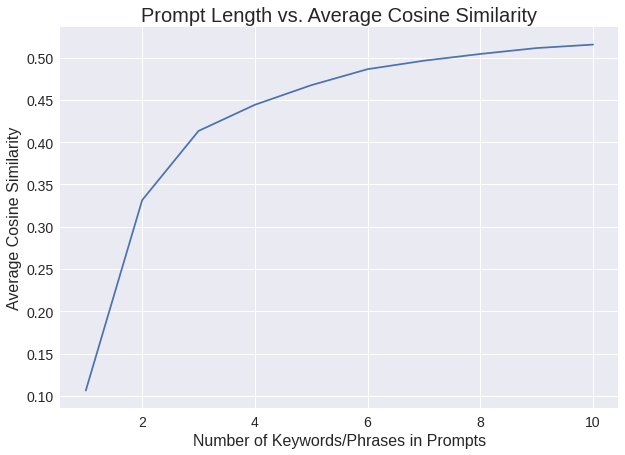

In [ ]:
#Plot length of prompts (in common separated values) vs. average cosine similarity
#Use the Seaborn style for cleaner looking plots
plt.style.use('seaborn')
#Establish the size of the plot
plt.figure(figsize=(10,7))
#Check how good of a fit this model is by plotting the regression line against the scatter plot of price vs. demand
plt.plot(results_df['length'],results_df['avg_cosine_sim'])
plt.xlabel('Number of Keywords/Phrases in Prompts',fontsize=16)
plt.ylabel('Average Cosine Similarity',fontsize=16)
plt.title('Prompt Length vs. Average Cosine Similarity',fontsize=20)
#Increase the tick sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)